<a href="https://colab.research.google.com/github/josedavidcortes-git/final_data/blob/main/pythonCode/FIPRODA_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Computer Science - CSC-557-U15-92793
# Nov 26, 2021
# Data Analysis, Decision Making, and Visualization
# Professor: Vijayalakshmi Saravanan
# Created By:
# Jose David Cortes (jose.d.cortes@coyotes.usd.edu | josedavidcortes.ai@gmail.com)
# Bhulakshmi Kunchala (bhulakshmi.kunchala@coyotes.usd.edu) 
# 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **ANALYSIS OF GREEN ENERGY IN EUROPE**
## (SOLAR & WIND)
## 2 of 3 
---

## dataset

This dataset contains hourly estimates of an area's energy potential for the range(years) 1986 to 2015 as a percentage of a power plant's maximum output.

In the previous exploratory analysis[1 of 3](https://colab.research.google.com/drive/1djvkc_OgooINAdV6EN2G3P15nFl4gnWv?usp=sharing), we have prepare clusters of countries with similar profiles of solar generation. 
In this 2nd part we're going to analyse and explore the data for every country representative of each cluster. As a reminder, here are what those 6 clusters made of :
 ***Cluster nb / Nb of countries in the cluster***


Countries (group) by cluster:

Cluster nb 0 :  Belgium, Germany, Denmark, France, Ireland, Luxembourg, Netherlands, United Kingdom,

Cluster nb 1 :  Austria, Bosnia and Herzegovina, Switzerland, Czech Republic, Croatia, Hungary, Italy, Slovenia, Slovakia

Cluster nb 2 :  Spain, Portugal,

Cluster nb 3 :  Albania, Bulgaria, Greece, Montenegro, Macedonia, Romania, Serbia, Kosovo,

Cluster nb 4 : Cyprus

Cluster nb 5 : Estonia, Finland, Lithuania, Latvia, Norway, Poland, Sweden

## Goals

- Estimate the impact of meteorological and climate variability on the generation of solar power in Europe.
- Understand how the datas are structured
- Determine how clean is the dataset? Older solar estimates used to contain impossible values around sunset (ie more energy than the sun releases) or negative sunlight.
- Show what does a typical year look like? One common approach is to stitch together 12 months of raw data, using the 12 most typical months per this ISO standard.

In [2]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

pd.options.display.max_columns = 300

import warnings
warnings.filterwarnings("ignore")

#let's see what our data set looks like
df_solar_co = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/datasets/EMHIRESPV_SOLAR_TSh_CF_Country.xlsx")
df_solar_co.head(2)

,Time_step,Date,Year,Month,Day,Hour,AL,AT,BA,BE,BG,CH,CY,CZ,DE,DK,EE,ES,FI,FR,EL,HR,HU,IE,IT,LT,LU,LV,ME,MK,NL,NO,PL,PT,RO,RS,SI,SK,SE,XK,UK
0,1,1986-01-01 00:00:00,1986,1,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1986-01-01 01:00:00,1986,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Lets take only one country of each cluster(to represent the cluster), and take a look a the end of the data set :


In [3]:
df_solar_co = df_solar_co[['NO', 'AT', 'FR', 'FI', 'RO', 'ES']]
df_solar_co.tail(2)

,NO,AT,FR,FI,RO,ES
262966,0.0,0.0,0.0,0.0,0.0,0.0
262967,0.0,0.0,0.0,0.0,0.0,0.0


**Data cleaning and preparation**

Until now we've consider that all datas are clean and "normal", but is it really the case ? We can easily verify that values are indeed between 0 and 1:

In [ ]:
print("Number of negative values :")
(df_solar_co[['NO', 'AT', 'FR', 'FI', 'RO', 'ES']] < 0).sum()

In [4]:
print("Number of values greater than 1 :")
(df_solar_co[['NO', 'AT', 'FR', 'FI', 'RO', 'ES']] > 1).sum()

Number of values greater than 1 :


NO    0
AT    0
FR    0
FI    0
RO    0
ES    0
dtype: int64

Now, we have to add date time information in order to use the data:

In [5]:
def add_time(_df):
    "Returns a DF with two new cols : the time and hour of the day"
    t = pd.date_range(start='1/1/1986', periods=df_solar_co.shape[0], freq = 'H')
    t = pd.DataFrame(t)
    _df = pd.concat([_df, t], axis=1)
    _df.rename(columns={ _df.columns[-1]: "time" }, inplace = True)
    _df['hour'] = _df['time'].dt.hour
    _df['month'] = _df['time'].dt.month
    _df['week'] = _df['time'].dt.week
    return _df

df_solar_co = add_time(df_solar_co)
df_solar_co.tail(2)

,NO,AT,FR,FI,RO,ES,time,hour,month,week
262966,0.0,0.0,0.0,0.0,0.0,0.0,2015-12-31 22:00:00,22,12,53
262967,0.0,0.0,0.0,0.0,0.0,0.0,2015-12-31 23:00:00,23,12,53


## **Data Analysis**

**Considering night and day**

Obviously, there is no generation of energy during the night :) But first, we're going to take a look at the distribution of the values of solar efficiency during different spans of time and generally. Let's begin with the last day of the records:

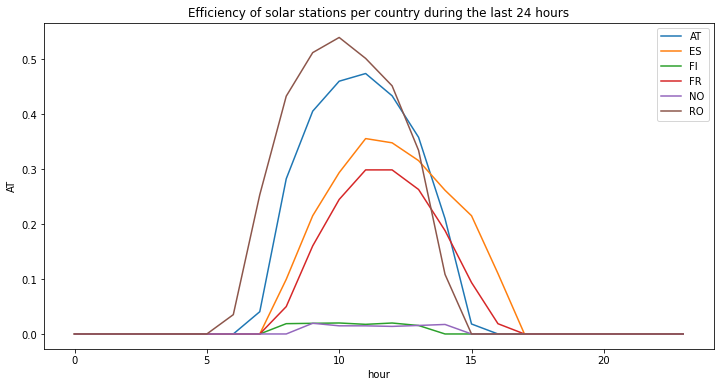

In [6]:
def plot_hourly(df, title):
    plt.figure(figsize=(12, 6))
    for c in df.columns:
        if c != 'hour':
            sns.lineplot(x="hour", y=c, data=df, label=c)
            #plt.legend(c)
    plt.title(title)
    plt.show()
    
plot_hourly(df_solar_co[df_solar_co.columns.difference(['time', 'month', 'week'])][-24:], "Efficiency of solar stations per country during the last 24 hours")

Values are normally distributed: the plot looks like a typical Gaussian distribution. The maximum efficiency during the day may vary among countries. Furthermore, there is an offset along the horizontal axis. This can be explained by the different longitude, the sun doesn't appear at the same hour depending on countries. Those observations can also be seen if we plot the means of those values during the hours of the day:

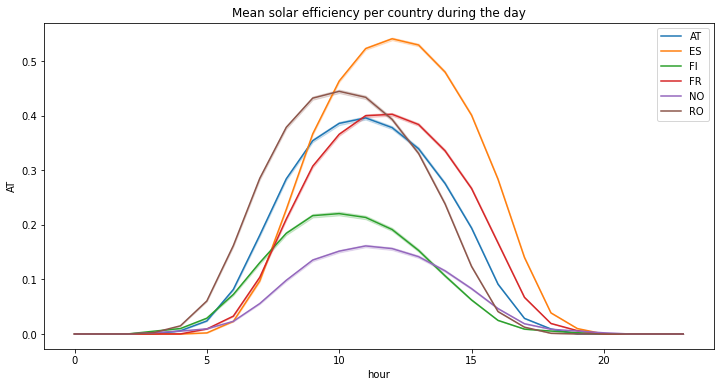

In [7]:
plot_hourly(df_solar_co[df_solar_co.columns.difference(['time', 'month', 'week'])], "Mean solar efficiency per country during the day")

Now let's look at a **statistical distribution**  of the station's efficiencies for non-null values (during the day), we can see that there are still many values (see the **spike**) around zero:

Text(0.5, 1.0, "Distribution of the station's efficiency for non null values (ie during the day)")

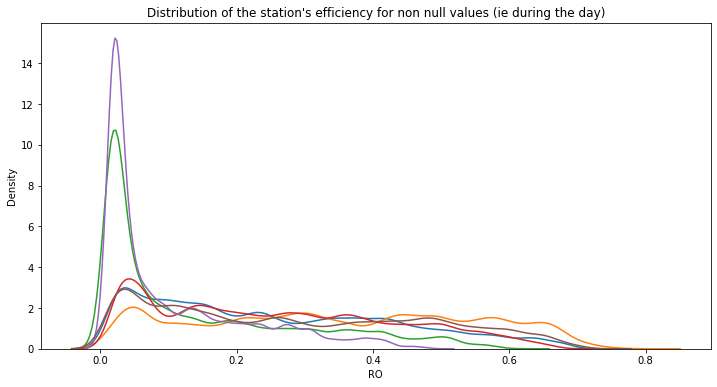

In [8]:
temp_df = df_solar_co[df_solar_co.columns.difference(['time', 'hour', 'month', 'week'])]
plt.figure(figsize=(12, 6))
for col in temp_df.columns:
    sns.distplot(temp_df[temp_df[col] != 0][col], label=col, hist=False)
plt.title("Distribution of the station's efficiency for non null values (ie during the day)")

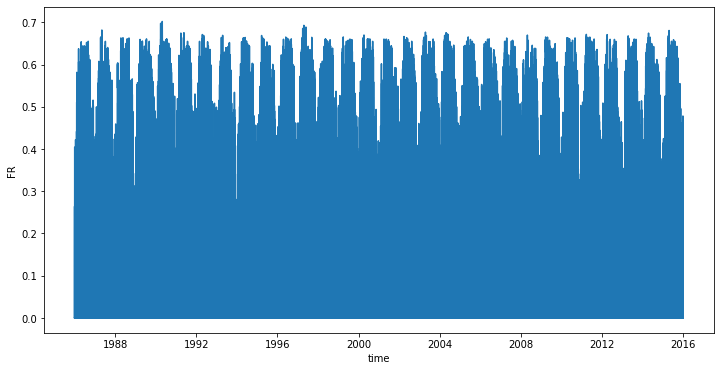

In [9]:
plt.figure(figsize=(12, 6))
sns.lineplot(x = df_solar_co.time, y = df_solar_co['ES'])

In order to understand more accurately this phenomenon, let's **plot** the **mean values per month**. As we can see, solar efficiency is better during the summer (which can be easily understood)

Text(0.5, 1.0, 'Efficiency across the months per country')

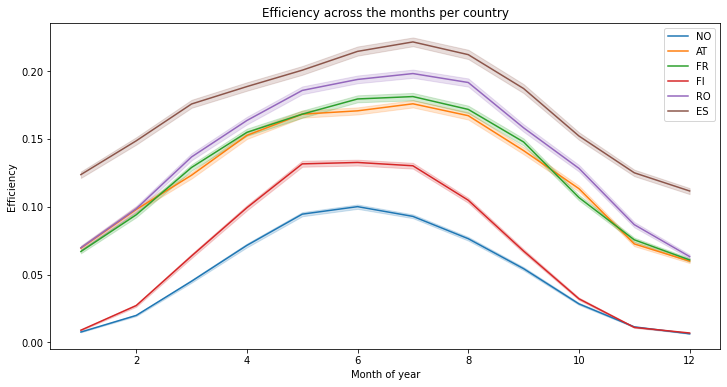

In [10]:
countries = ['NO', 'AT', 'FR', 'FI', 'RO', 'ES']

plt.figure(figsize=(12, 6))
for c in countries:
    temp_df = df_solar_co[[c, 'month']]
    sns.lineplot(x=temp_df["month"], y=temp_df[c], label=c)
    
plt.xlabel("Month of year")
plt.ylabel("Efficiency") 
plt.title("Efficiency across the months per country")

We can observe the same thing, with **means** on a **weekly** basis, there is finally no real variations:

Text(0.5, 1.0, 'Efficiency across the weeks per country')

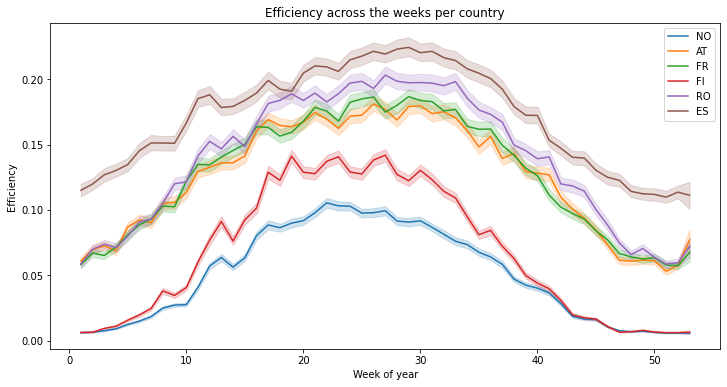

In [11]:
plt.figure(figsize=(12, 6))
for c in countries:
    temp_df = df_solar_co[[c, 'week']]
    sns.lineplot(x=temp_df["week"], y=temp_df[c], label=c)
    
plt.xlabel("Week of year")
plt.ylabel("Efficiency") 
plt.title("Efficiency across the weeks per country")

We create a temporary dataframe with the year, in order to see the variation of the mean solar efficiency accross 30 years. As you can see, the solar generation is quite the same years after years:

Text(0.5, 1.0, 'Efficiency across the years per country')

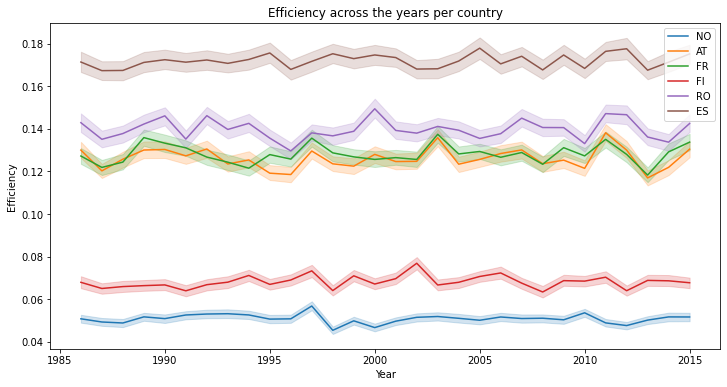

In [12]:
temp_df = df_solar_co.copy()
temp_df['year'] = temp_df['time'].dt.year


plt.figure(figsize=(12, 6))
for c in countries:
    temp_df_ = temp_df[[c, 'year']]
    sns.lineplot(x=temp_df_["year"], y=temp_df_[c], label=c)
    
plt.xlabel("Year")
plt.ylabel("Efficiency") 
plt.title("Efficiency across the years per country")

Considering **ONLY** values between 5 AM & 10 PM (sunlight hours)
We're going to take an other look at the distribution of the values but this same considering only during the sunlight hours of the day. Let's begin with a summary of the statistics:

In [13]:
temp_df = df_solar_co[(5 < df_solar_co.hour) & (df_solar_co.hour < 22)]
temp_df = temp_df.drop(columns=['time', 'hour', 'month', 'week'])
temp_df.describe()

,NO,AT,FR,FI,RO,ES
count,175312.000000,175312.000000,175312.000000,175312.000000,175312.000000,175312.000000
mean,0.075220,0.187375,0.191680,0.099533,0.204717,0.257699
std,0.103796,0.191641,0.187002,0.142873,0.211509,0.228028
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.025330,0.131469,0.147011,0.020212,0.133705,0.233841
75%,0.111076,0.335664,0.339958,0.157080,0.386842,0.458925
max,0.487921,0.715303,0.701985,0.615942,0.722990,0.793842


Then, we can **plot** the values of the 3rd quartile (splits off the highest 25% of data from the lowest 75%) for each country :

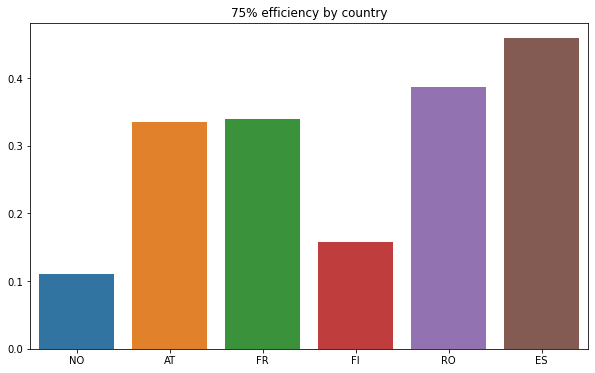

In [14]:
def plot_by_country(_df, title, nb_col):
    _df = _df.describe().iloc[nb_col, :]
    plt.figure(figsize=(10, 6))
    sns.barplot(x=_df.index, y=_df.values)
    plt.title(title)

#plot_by_country("Mean efficiency by country", 1)
plot_by_country(temp_df, "75% efficiency by country", 6)

Another way to look at the distribution can be achieved with **violin plots**  (a method of plotting numeric data. It is similar to a box plot, with the addition of a rotated kernel density plot on each side):

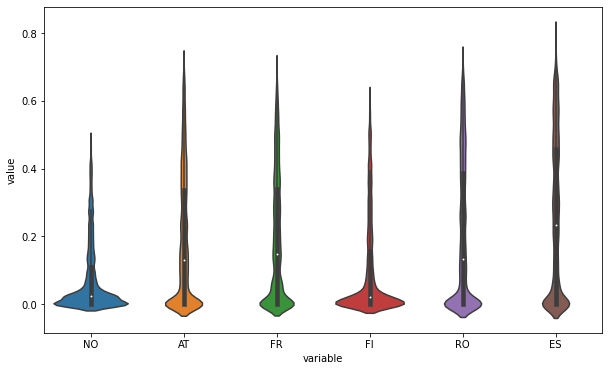

In [15]:
# This works because pd.melt converts a wide-form dataframe
plt.figure(figsize=(10, 6))
sns.violinplot(x="variable", y="value", data=pd.melt(temp_df))

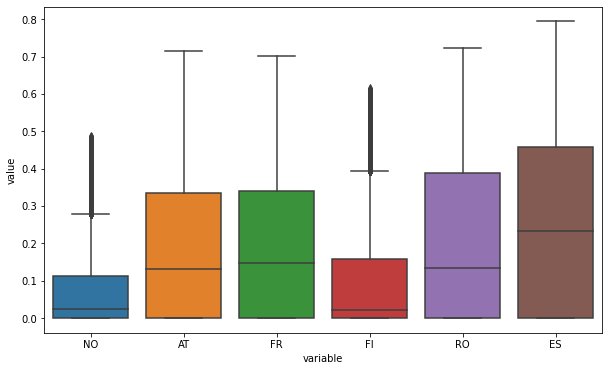

In [16]:
plt.figure(figsize=(10, 6))
sns.boxplot(x="variable", y="value", data=pd.melt(temp_df))

And finally the **distribution**, we can see that Norway and Finland present many more values around zero:

Text(0.5, 1.0, "Distribution of the station's efficiency")

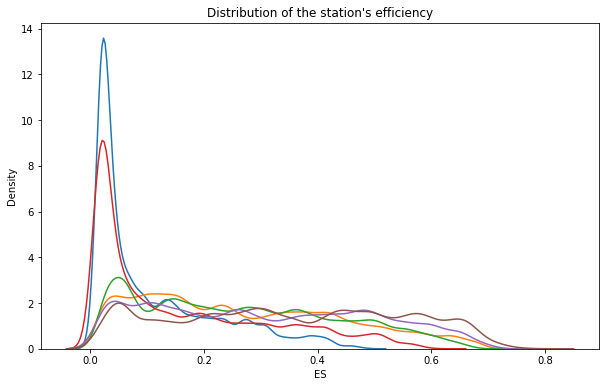

In [17]:
plt.figure(figsize=(10, 6))
for col in temp_df.columns:
    sns.distplot(temp_df[temp_df[col] != 0][col], label=col, hist=False)
plt.title("Distribution of the station's efficiency")

# Correlations

Is there any dependence between the solar generation among countries?

In statistics, correlation or dependence is any statistical relationship, whether causal or not, between two random variables. In the broadest sense correlation is any statistical association, though it commonly refers to the degree to which a pair of variables are linearly related.

Correlations are useful because they can indicate a predictive relationship that can be exploited in practice.

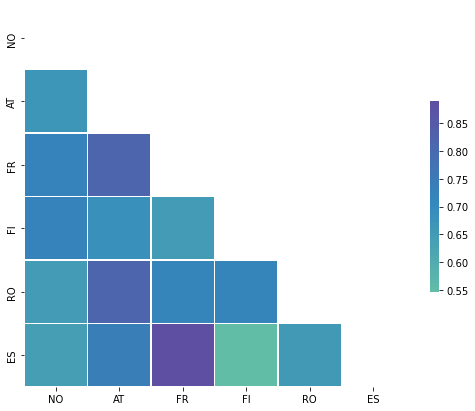

In [18]:
def plot_corr(df_):
    corr = df_.corr()
    corr

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(9, 7))

    # Generate a custom diverging colormap
    #cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, center=0, square=True, cmap='Spectral', linewidths=.5, cbar_kws={"shrink": .5}) #annot=True
    
plot_corr(temp_df)

Since values are higher than 0.6, there are considered highly positively correlated. Once again, this is not surprising because the countries are situated close to each other, so the sun has a tendency to rise and set at the same time and in the same way for all those countries. Another way to see those correlations is to show the following matrix:

In [19]:
temp_df.corr()

,NO,AT,FR,FI,RO,ES
NO,1.000000,0.668562,0.724858,0.723009,0.648708,0.641740
AT,0.668562,1.000000,0.818610,0.684129,0.819165,0.741216
FR,0.724858,0.818610,1.000000,0.646947,0.718909,0.888815
FI,0.723009,0.684129,0.646947,1.000000,0.718531,0.547065
RO,0.648708,0.819165,0.718909,0.718531,1.000000,0.653520
ES,0.641740,0.741216,0.888815,0.547065,0.653520,1.000000


## Heatmap month vs hours

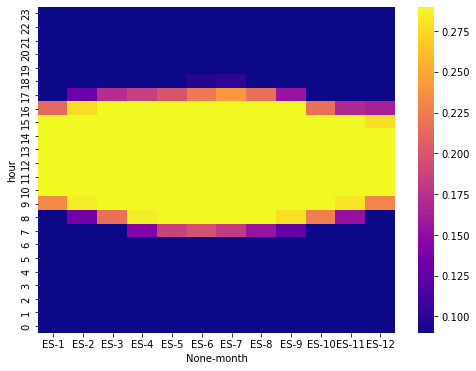

In [20]:
df_solar_co['year'] = df_solar_co['time'].dt.year
plt.figure(figsize=(8, 6))
temp_df = df_solar_co[['ES', 'month', 'hour']]
temp_df = temp_df.groupby(['hour', 'month']).mean()
temp_df = temp_df.unstack('month').sort_index(ascending=False)
sns.heatmap(temp_df, vmin = 0.09, vmax = 0.29, cmap = 'plasma')

In this second part, we have explored the data set in order to assess the impact of meteorological and climate variability on the generation of solar power. We've also shown the variation during the day, the months of the year and accross years. The dataset seems to be clean and a function to add date time informations is already implemented. It will be usefull in the third( [3 of 3](https://colab.research.google.com/drive/1RxV1hKyXh0B4SdL0mDT_7S-HN2l7R20c?usp=sharing) ) and final part of this study where we'll train machine learning models to make predictions.